In [488]:
#import libraries
import tables
from tables import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagehash

In [489]:
#function to retrieve parameter values from cta dataset
def values_from_h5file(fname,imgname):
    file = tables.open_file(fname,"r")
    #visualize images from the telescope
    img = file.root.dl1.event.telescope.images.LST_LSTCam.col("image")
    px_row = file.root.instrument.telescope.camera.LSTCam.col("pix_x")
    px_col = file.root.instrument.telescope.camera.LSTCam.col("pix_y")

    # retrieve most interesting events
    tab_good_event = [event for event in img if event.std()>30]
    #print(len(tab_good_event))

    htable = np.fromfile("injunction_table_lst.pny", offset=8, dtype=np.uint16)
    matrix = np.zeros(55*55)
    matrix[htable] = tab_good_event[0]
    res = matrix.reshape(55,55)

    plt.figure(figsize=(12,8))
    plt.scatter(px_row,px_col,c=tab_good_event[0],s=100)
    plt.colorbar()
    plt.axis("equal")
    plt.imsave(imgname,res)

    #compute image hash with perceptual hash
    hash = imagehash.phash(Image.open(imgname))
    #retrieving some parameters of the simulated images
    E = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_energy")
    h = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_h_first_int")
    x = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_core_x")
    y = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_core_y")
    Imax = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_x_max")
    eventId = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("event_id")
    #retrieving parameters of the telescope
    pos_x = file.root.instrument.subarray.layout.col("pos_x")
    pos_y = file.root.instrument.subarray.layout.col("pos_y")

    return x, y, pos_x, pos_y, E, h, Imax, eventId, img, px_row, px_col, tab_good_event, hash, res

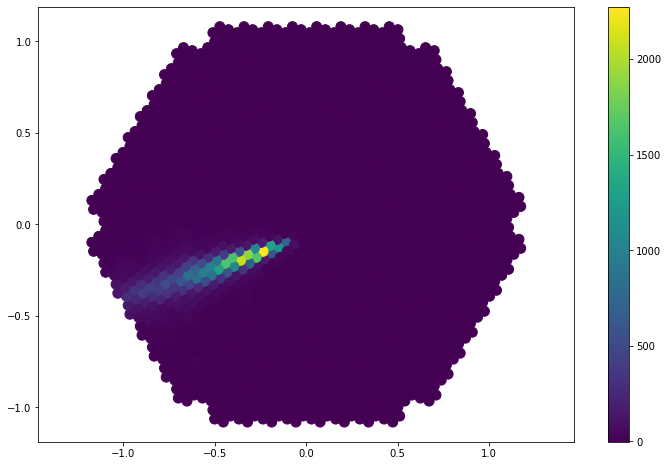

In [490]:
#file test
ftest = values_from_h5file("Data/testing/dl1v06_reorganized_gamma_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5","imgrun1.png")
#len(ftest)

In [491]:
#retrieving some parameters of the simulated images
E1 = ftest[4]
h1 = ftest[5]
x1 = ftest[0]
y1 = ftest[1]
Imax1 = ftest[6]
eventId1 = ftest[7]
img1 = ftest[8]
px_row1 = ftest[9]
px_col1 = ftest[10]
tab_good_event1 = ftest[11]
hash1 = ftest[12]
pos_x1 = ftest[2]
pos_y1 = ftest[3]
res1 = ftest[13]

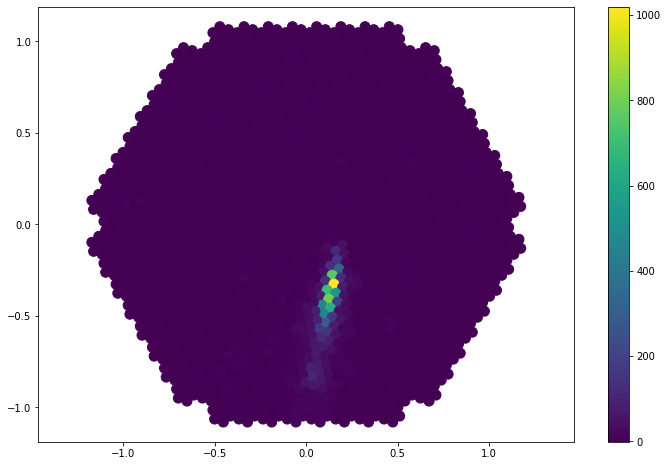

In [492]:
#file train
ftrain = values_from_h5file("Data/training/dl1v06_reorganized_gamma_20deg_180deg_run4___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5","imgrun4.png")
#len(ftrain)

In [493]:
#retrieving some parameters of the simulated images
E2 = ftrain[4]
h2 = ftrain[5]
x2 = ftrain[0]
y2 = ftrain[1]
Imax2 = ftrain[6]
eventId2 = ftrain[7]
img2 = ftrain[8]
px_row2 = ftrain[9]
px_col2 = ftrain[10]
tab_good_event2 = ftrain[11]
hash2 = ftrain[12]
pos_x2 = ftrain[2]
pos_y2 = ftrain[3]
res2 = ftrain[13]

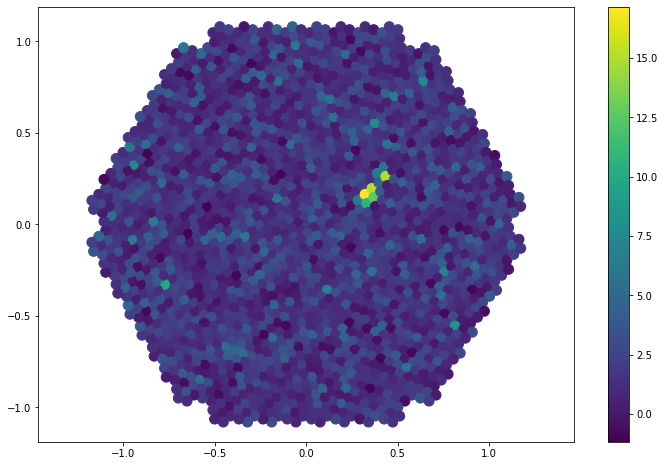

In [494]:
#visualize images from the telescope

plt.figure(figsize=(12,8))
plt.scatter(px_row2,px_col2,c=img2[0],s=100)
plt.colorbar()
plt.axis("equal")
plt.show()

In [505]:
img2.shape

(2083, 1855)

In [495]:
#compute alpha angle at position j
def angle(j,x,y,pos_x,pos_y):
    alpha = []
    for i in range(x.size):
        tmp = np.math.atan2(y[i]-pos_y[j],x[i]-pos_x[j]) *  180 / np.pi
        alpha.append(tmp)

    return alpha

alpha1 = angle(0,x1,y1,pos_x1,pos_y1)
alpha2 = angle(0,x2,y2,pos_x2,pos_y2)

In [496]:
# Applying SVD
U2, S2, VT2 = np.linalg.svd(res2,full_matrices=False,# It's not necessary to compute the full matrix of U or V
      compute_uv=True) # Deterministic SVD

S2 = np.diag(S2) #singular value matrix
sv2 = []
for i in range(55):
      sv2.append(S2[i][i])
#sv

In [497]:
# Applying SVD
U1, S1, VT1 = np.linalg.svd(res1,full_matrices=False,# It's not necessary to compute the full matrix of U or V
      compute_uv=True) # Deterministic SVD

S1 = np.diag(S1) #singular value matrix
sv1 = []
for i in range(55):
      sv1.append(S1[i][i])
#sv

In [498]:
#compute impact parameter
def cip(j,x,y,pos_x,pos_y):
    impact = []
    for i in range(x.size):
        dist2 = np.square(x[i]-pos_x[j]) + np.square(y[i]-pos_y[j])
        impact.append(np.sqrt(dist2))

    return impact

In [499]:
ro1 = cip(0,x1,y1,pos_x1,pos_y1) #impact parameter at position 0
ro2 = cip(0,x2,y2,pos_x2,pos_y2) #impact parameter at position 0

In [500]:
#creating tables for datasets
class Mc_shower(IsDescription):
    name = StringCol(16)
    idevent = UInt64Col()
    energy = Float32Col()
    hfirstint = Float32Col()
    Imax = Float32Col()
    impact = Float32Col()
    x = Float32Col()
    y = Float32Col()
    hash = StringCol(64)
    sv = Float64Col(shape=55)
    alpha = Float64Col()

h5file = open_file("sim_img.h5",mode ="w", title="Simulated image file")
#create a group
group = h5file.create_group("/",'Shower','Shower Info')

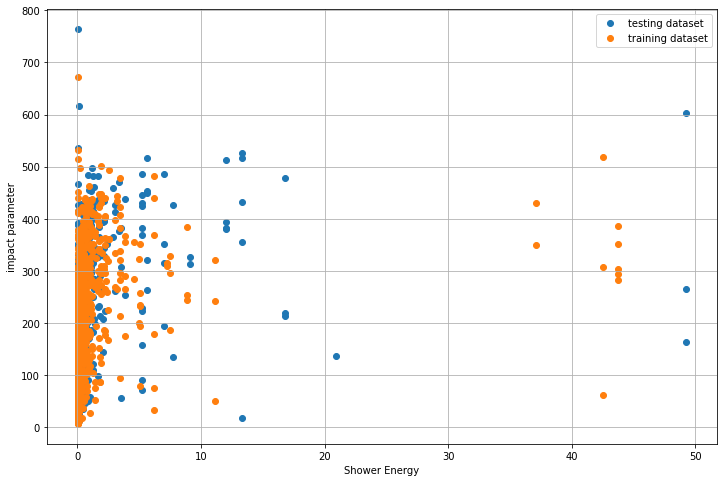

In [501]:
#create tables
for tablename in ('gerbe1','gerbe2'):
    #create a table
    table = h5file.create_table(group,tablename,Mc_shower,"mc_shower: "+tablename)
    #now let's fill the table with its values
    gerbe = table.row #write data rows into the table

    if tablename=='gerbe2':
        for i in range(len(eventId2)):
            gerbe['name'] = f'Event: {i:6d}'
            gerbe['idevent'] = eventId2[i]
            gerbe['energy'] = E2[i]
            gerbe['hfirstint'] = h2[i]
            gerbe['x'] = x2[i]
            gerbe['y'] = y2[i]
            gerbe['Imax'] = Imax2[i]
            gerbe['impact'] = ro2[i]
            gerbe['hash'] = hash2
            gerbe['sv'] = sv2
            gerbe['alpha'] = alpha2[i]
            #insert a new gerbe record

            gerbe.append()

    if tablename=='gerbe1':
        for i in range(len(eventId1)):
            gerbe['name'] = f'Event: {i:6d}'
            gerbe['idevent'] = eventId1[i]
            gerbe['energy'] = E1[i]
            gerbe['hfirstint'] = h1[i]
            gerbe['x'] = x1[i]
            gerbe['y'] = y1[i]
            gerbe['Imax'] = Imax1[i]
            gerbe['impact'] = ro1[i]
            gerbe['hash'] = hash1
            gerbe['sv'] = sv1
            gerbe['alpha'] = alpha1[i]
            #insert a new gerbe record

            gerbe.append()

    table.flush()

#We have our data on disk, and now we need to access it and select from specific columns the values we are interested in
table1 = h5file.root.Shower.gerbe1
table2 = h5file.root.Shower.gerbe2

plt.figure(figsize=(12,8))
plt.scatter(table1.col("energy"),table1.col('impact'),label="testing dataset")
plt.scatter(table2.col("energy"),table2.col('impact'),label="training dataset")
plt.legend()
plt.xlabel("Shower Energy")
plt.ylabel("impact parameter")
plt.grid()
plt.show()

In [502]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA

#Scale data before applying PCA
scaling = StandardScaler()

df = pd.DataFrame(data=table1.col("energy"))
other = pd.DataFrame(data=table1.col('impact'))
test_data = df.join(other,how="left",  lsuffix = '_left', rsuffix = '_right')

df2 = pd.DataFrame(data=table2.col("energy"))
other2 = pd.DataFrame(data=table2.col('impact'))
train_data = df2.join(other2,how="left",  lsuffix = '_left', rsuffix = '_right')

data = train_data.join(test_data,how="left",  lsuffix = '_left', rsuffix = '_right')

#use fit and transform method
scaling.fit(data)
Scaled_data = scaling.transform(data)

#set the n_components=3
principal = PCA(n_components=3)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)

#check the dimensions of data after PCA
print(x.shape)


(2083, 3)


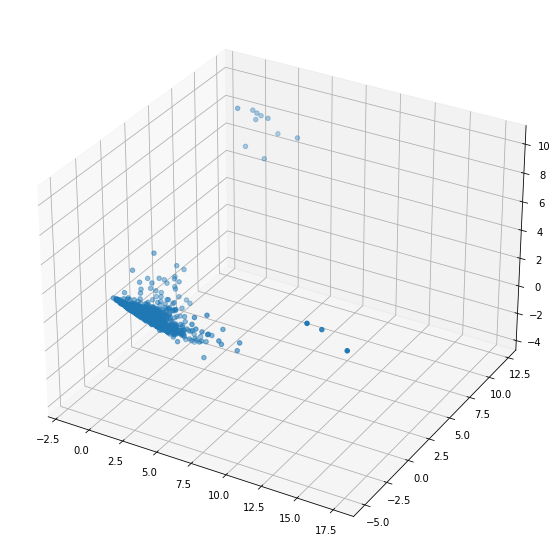

In [503]:
#import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
#choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111,projection='3d')

axis.scatter(x[:,0],x[:,1],x[:,2])

In [504]:
h5file.close()